<a href="https://colab.research.google.com/github/boqchen/Mathematical-Foundations-of-Computer-Graphics-and-Vision---SS21/blob/main/MATHFOUND21_1_Boqi_Chen_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MATHEMATICAL FOUNDATIONS OF COMPUTER GRAPHICS AND VISION**
 
EXERCISE 1 - ROBUST ESTIMATION AND OPTIMIZATION
 
Boqi Chen (20-953-048)

**1. RANSAC FOR CIRCLE FITTING**

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from scipy.linalg import null_space
from itertools import combinations
from datetime import datetime
import time
from scipy.optimize import linprog


The function *generate_circle_data_points* takes the model parameters, i.e., center coordinates and radius, outlier ratio, inlier distance threshold $\tau$ (by default $\tau=0.1$ in this exercise) and number of sample points (by default $N=100$ in this exercise) as arguments and returns the coordiantes of sampling data points including inliers and outliers. The points are generated according to polar coordinates, $$(x,y)=(r\cos\theta+x_c, r\sin\theta+y_c)$$ where $r$ and $(x_c, y_c)$ is the radius and center of the circle and $\theta$ is the angle bewteen the vector $(x-x_c,y-y_c)$ and $(x,0)$. To generate inliers, $\theta$ is randomly sampled in the range of $[0, 2\pi]$. Also, random noise in the range of $[-1,1]$ is added to the radius. Thus, the coordinates of inliers are, $$(x,y)=((r+n)\cos\theta+x_c, (r+n)\sin\theta+y_c)$$ where n is therandom noise in the range of $[-1,1]$. To generate outliers, the points are firstly randomly sampled in the domain $[-10, 10]\times[-10, 10]$ and then verified such that the distance between the sampled points and the circle $$\vert\sqrt{(x-x_c)^2+(y-y_c)^2}-r\vert>\tau$$ where $\tau$ is the inlier distance threshold. After successfully generating the inliers and outliers, the data matrix is shuffled.








In [2]:
def generate_circle_data_points(x_c=None, y_c=None, radius=None, outlier_ratio=None, tau=0.1, N=100):
    # (x_c, y_c) is the center of the circle and radius is the radius of the circle
    # outlier_ratio: the ratio of outliers, i.e. points that don’t follow the “circle” rule at all
    # tau: the inlier distance threshold, in this exercise tau = 0.1
    # N: number of points, in this exercise N=100  
    
    inlier_ratio = 1 - outlier_ratio
    n_outliers = int(N * outlier_ratio)
    n_inliers = int(N * inlier_ratio)

    # add random noise to radius between -0.1 to 0.1
    noise_range = 0.1 
    noise = (2 * noise_range) * np.random.rand(1, n_inliers) - noise_range
    r = radius + noise

    # generate inliers  
    theta = np.random.rand(1, n_inliers) * 2 * math.pi
    x_in = r * np.cos(theta) + x_c
    y_in = r * np.sin(theta) + y_c

    # generate outliers
    x_out = np.zeros((1, n_outliers))
    y_out = np.zeros((1, n_outliers))

    domain_upper_bound = 10
    domain_lower_bound = -10

    i = 0
    while i < n_outliers:
      x_temp = (domain_upper_bound - domain_lower_bound) * random.uniform(0, 1) + domain_lower_bound
      y_temp = (domain_upper_bound - domain_lower_bound) * random.uniform(0, 1) + domain_lower_bound
      
      distance = abs(math.sqrt((x_temp - x_c) ** 2 + (y_temp - y_c) ** 2) - radius)

      # verify if created point is truly outlier
      if distance > tau:
        x_out[0][i] = x_temp
        y_out[0][i] = y_temp
        i = i+1

    x = np.hstack((x_in, x_out))
    y = np.hstack((y_in, y_out))
    indices = np.array(list(range(len(x))))
    random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    data = np.vstack((x,y))
    
    return data

The function *circle_fit* fits three sample points to a circle: $$a(x^2+y^2)+bx+cy+1=0$$ where $(x,y)$ is the coordinates of the sample point. 

Given three points $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$, we can fit the circle by: $$a(x_1^2+y_1^2)+bx_1+cy_1+1=0\\a(x_2^2+y_2^2)+bx_2+cy_2+1=0\\a(x_3^2+y_3^2)+bx_3+cy_3+1=0$$

The parameters of the fitted circle is give by: $$(x_c,y_c)=(-\frac{b}{2a},-\frac{c}{2a})\\r=\frac{\sqrt{b^2+c^2-4a}}{2a}$$
Writing in matrix notation, we have $$
\left [
\begin{matrix}
x_1^2+y_1^2 & x_1 & y_1 & 1 \\
x_2^2+y_2^2 & x_2 & y_2 & 1 \\
x_2^3+y_2^3 & x_3 & y_3 & 1
\end{matrix}
\right ]\left [
\begin{matrix}
a \\ b \\c \\1
\end{matrix}
\right ] = 0
$$ The right null space of the left matrix gives the solution to this linear system.

Reference: https://cseweb.ucsd.edu/classes/wi16/cse252B-a/nullspace.pdf

In [3]:
def circle_fit(point_1=None, point_2=None, point_3=None):

    # circle model: a(x2 + y2) + bx + cy + 1 = 0
    # homogenous equation: Ax = 0 for 3 points

    x_1 = point_1[0]
    y_1 = point_1[1]

    x_2 = point_2[0]
    y_2 = point_2[1]

    x_3 = point_3[0]
    y_3 = point_3[1]


    A=np.array([
                [x_1**2+y_1**2, x_1, y_1, 1],
                [x_2**2+y_2**2, x_2, y_2, 1],
                [x_3**2+y_3**2, x_3, y_3, 1]
    ])


    ns = null_space(A)

    coefficient = ns/ns[-1][-1] # normalize s.t. homogeneous form
   
    a = coefficient[0][0]
    b = coefficient[1][0]
    c = coefficient[2][0]

    if a == 0:
        x_c_fit = 0
        y_c_fit = 0
        r_fit = 0
    else:
        x_c_fit = -b / (2 * a)
        y_c_fit = -c / (2 * a)
        r_fit = math.sqrt(abs(b ** 2 + c ** 2 - 4 * a)) / abs(2 * a)
    
    return x_c_fit, y_c_fit, r_fit
        

The function *circle_ransac* performs RANSAC algorithm. It takes data matrix, number of RANSAC iterations at a certain guaranteed accuracy and the threshold of the distances between points and the fitting line as arguments and returns the circle parameters of the fitted circle and the inliers that corresponds to this circle model. The number of iterations is given by $$N=\lceil\frac{\log(1-p)}{\log(1-(1-r)^s)}\rceil$$ where $p$ is the guaranteed accuracy, i.e., confidence, r is the outlier ratio and s is the minimal number of the sample points that fit the model, in circle fitting $s=3$.

In [4]:
def circle_ransac(data=None, iterations=None, threshold=None):
    # data: 2 x n matrix with n data points
    # iter: number of RANSAC iterations given a certain guaranteed accuracy 
    # threshold: the threshold of the distances between points and the fitting line
    # xc, yc, r: best fitted circle's parameters
    # inliers: 2 x m matrix with inlier points for best fitted circle

    n_points = data.shape[1] # total number of points
    best_n_inliers = 0 # largest number of inliers 
    x_c = 0
    y_c = 0
    r = 0

    x = data[0, :]
    y = data[1, :]

    for i in range(iterations):

        # randomly select 3 points and fit circle to these points
        indices = np.random.permutation(n_points)[:3]
        point_1 = data[:, indices[0]]
        point_2 = data[:, indices[1]]
        point_3 = data[:, indices[2]]

        x_c_temp, y_c_temp, r_temp = circle_fit(point_1, point_2, point_3)

        # compute the distances between all points with the fitting circle
        distances = np.abs(np.sqrt((x - x_c_temp) ** 2 + (y - y_c_temp) ** 2) - r_temp)

        # find the inliers (distances smaller than the threshold)
        is_inlier = distances <= threshold
        is_outlier = np.logical_not(is_inlier)
        n_inliers = sum(is_inlier)
        

        # update the number of inliers and fitting model if better model is found
        if n_inliers >= best_n_inliers:
            inliers = data[:, is_inlier]
            outliers = data[:, is_outlier]
            x_c = x_c_temp
            y_c = y_c_temp
            r = r_temp
            best_n_inliers = n_inliers
        
    return x_c, y_c, r, inliers, outliers
   

The function *exhaustive_search* performs exhaustive search. The difference beetween exhaustve search and RANSAC algorithms is that when performing exhaustive search, the three points which are used to fit the circle is not randomly selected but exhaustively tried. That is to say, every possible combination of three points as a set of sample points to fit a circle is attempted. Thus, the number of iteration is givn by $$n=C_N^s=C_{100}^3=161700$$ where $N$ is the number of total data points and $s$ is the number of data points to fit a circle.

In [5]:
def exhaustive_search(data=None, threshold=None):

  best_inliers_exhaustive = np.zeros((0, 0))
  best_n_inliers = 0 # largest number of inliers 
  x_c = 0
  y_c = 0
  r = 0

  x = data[0, :]
  y = data[1, :]

  # all combinations for 100 points 
  all_comb = np.array(list(combinations(np.arange(100),3)))
  for i in range(all_comb.shape[0]):
    point_1 = data[:, all_comb[i][0]]
    point_2 = data[:, all_comb[i][1]]
    point_3 = data[:, all_comb[i][2]]

    x_c_temp, y_c_temp, r_temp = circle_fit(point_1, point_2, point_3)

    # compute the distances between all points with the fitting circle
    distances = np.abs(np.sqrt((x - x_c_temp) ** 2 + (y - y_c_temp) ** 2) - r_temp)

    is_inlier = distances <= threshold
    n_inliers = sum(is_inlier)

    if n_inliers >= best_n_inliers:
      
      inliers = data[:, is_inlier]
      x_c = x_c_temp
      y_c = y_c_temp
      r = r_temp
      best_n_inliers = n_inliers

  return x_c, y_c, r, inliers





  

    


The following section gives the results of RANSAC and exhaustive search algorithms to fit a circle given noisy data. The true parameters of the circle are chosen to be $$(x_c,y_c)=(0,0)\\ r=5$$ The accuracy is set to 0.99 and the outlier ratios are $0.05, 0.2, 0.3, 0.7$. To get the distribution of the number of inliers found by RANSAC in a histogram, the RANSAC is reapplied 1000 times, to populate the histogram. 

Circle Center: 0 0
Circle Radius: 5
------------- outlier ratio is:  0.05 --------------------



---------------- RANSAC ---------------------------------
average running time of RANSAC: 0.0016571123600006103
average number of inliers of RANSAC: 65.712
maximum number of inliers of RANSAC: 94.0
median number of inliers of RANSAC: 70.0
standard deviation of inliers of RANSAC: 16.53937894843697
---------------- Exhaustive Search------------------------
running time of exhaustive search: 60.43256235122681
number of inliers of exhaustive search: 95
------------- outlier ratio is:  0.2 --------------------



---------------- RANSAC ---------------------------------
average running time of RANSAC: 0.003280489921569824
average number of inliers of RANSAC: 58.208
maximum number of inliers of RANSAC: 79.0
median number of inliers of RANSAC: 63.0
standard deviation of inliers of RANSAC: 13.906068315667085
---------------- Exhaustive Search------------------------
running time of exhaustive search: 62.82326006889343
number of inliers of exhaustive search: 80
------------- outlier ratio is:  0.3 --------------------



---------------- RANSAC ---------------------------------
average running time of RANSAC: 0.005056561470031739
average number of inliers of RANSAC: 52.455
maximum number of inliers of RANSAC: 69.0
median number of inliers of RANSAC: 55.0
standard deviation of inliers of RANSAC: 10.946505150046749
---------------- Exhaustive Search------------------------
running time of exhaustive search: 64.3423662185669
number of inliers of exhaustive search: 70
------------- outlier ratio is:  0.7 --------------------



---------------- RANSAC ---------------------------------
average running time of RANSAC: 0.08296754312515259
average number of inliers of RANSAC: 23.086
maximum number of inliers of RANSAC: 30.0
median number of inliers of RANSAC: 24.0
standard deviation of inliers of RANSAC: 4.420701754246717
---------------- Exhaustive Search------------------------
running time of exhaustive search: 62.60056805610657
number of inliers of exhaustive search: 30


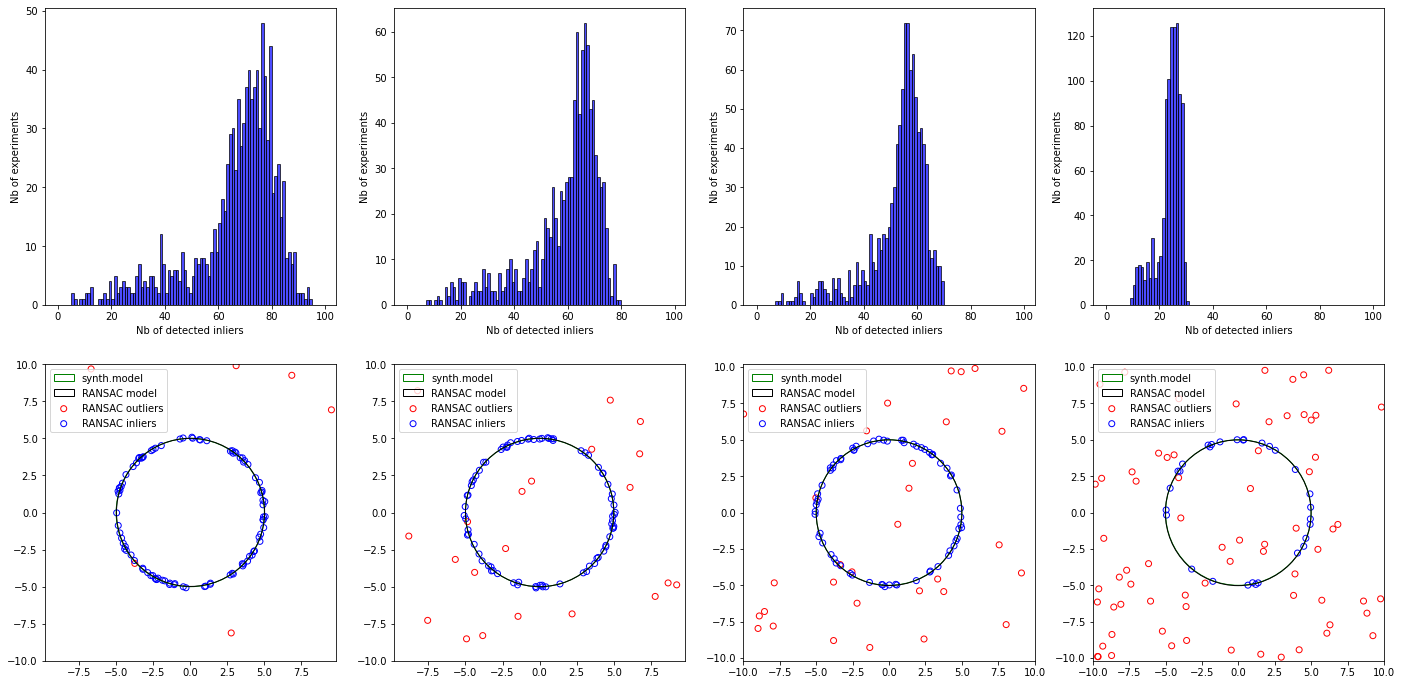

In [8]:
from tqdm.notebook import tqdm

# true circle parameters 
x_c = 0
y_c = 0
r = 5

print('Circle Center:', x_c, y_c);
print('Circle Radius:', r);

p = 0.99
s = 3

outlier_ratios = [0.05, 0.2, 0.3, 0.7]

fig, axs = plt.subplots(2,4)
fig.set_size_inches((24,12))

for i in range(len(outlier_ratios)):
  
  random.seed(datetime.now())
  best_inliers_fit = np.zeros((0, 0))
  inlier_counts = np.zeros((1, 1000))
  print('------------- outlier ratio is: ', outlier_ratios[i], '--------------------')
  data = generate_circle_data_points(x_c, y_c, r, outlier_ratios[i])
  x = data[0, :]
  y = data[1, :]
  n_iterations = math.ceil(math.log(1 - p) / math.log(1 - (1 - outlier_ratios[i]) ** s))
      
  start = time.time()
  for j in tqdm(range(1000)):

    x_c_fit, y_c_fit, r_fit, inliers_fit, outliers_fit = circle_ransac(data, n_iterations, 0.1)
    inlier_count = inliers_fit.shape[1]
    inlier_counts[0][j] = inlier_count
          
    if inlier_count >= best_inliers_fit.shape[1]:

      best_x_c_fit = x_c_fit
      best_y_c_fit = y_c_fit
      best_r_fit = r_fit
      best_inliers_fit = inliers_fit
      best_outliers_fit = outliers_fit

  end = time.time()
  inlier_count_mean = np.mean(inlier_counts)
  inlier_count_max = np.max(inlier_counts)
  inlier_count_median = np.median(inlier_counts)
  inlier_count_std = np.std(inlier_counts)

  print('---------------- RANSAC ---------------------------------')
  print('average running time of RANSAC:', (end-start)/1000)
  print('average number of inliers of RANSAC:', inlier_count_mean)
  print('maximum number of inliers of RANSAC:', inlier_count_max)
  print('median number of inliers of RANSAC:', inlier_count_median)
  print('standard deviation of inliers of RANSAC:', inlier_count_std)

  start_exhaustive = time.time() 
  x_c_fit_ex, y_c_fit_ex, r_fit_ex, inliers_fit_ex = exhaustive_search(data, 0.1)
  end_exhaustive = time.time()
  print('---------------- Exhaustive Search------------------------')
  print('running time of exhaustive search:', end_exhaustive-start_exhaustive)
  inlier_count_ex = inliers_fit_ex.shape[1]
  print('number of inliers of exhaustive search:', inlier_count_ex)

  axs[0,i].hist(inlier_counts[0], bins=np.arange(0,100), facecolor="blue", edgecolor="black", alpha=0.7)
  axs[0,i].set(xlabel='Nb of detected inliers', ylabel='Nb of experiments')
  axs[1,i].scatter(best_outliers_fit[0,:], best_outliers_fit[1,:], facecolors='none', edgecolors='r', label = 'RANSAC outliers')
  axs[1,i].scatter(best_inliers_fit[0,:], best_inliers_fit[1,:], facecolors='none', edgecolors='b', label = 'RANSAC inliers')
  axs[1,i].axis('equal')
  axs[1,i].set_xlim(-10, 10)
  axs[1,i].set_ylim(-10, 10)

  # plot the circle
  circle1 = plt.Circle((x_c, y_c), r, color='g', fill=False, label='synth.model')
  circle2 = plt.Circle((best_x_c_fit, best_y_c_fit), best_r_fit, color='black', fill=False, label='RANSAC model')
  axs[1,i].add_patch(circle1)
  axs[1,i].add_patch(circle2)
  axs[1,i].legend(loc='upper left')  


**Discussion**


> **Results**

The following figure (from left to right) shows the results of RANSAC with outlier ratios of $0.05, 0.2, 0.3, 0.7$ each respectively.

![](https://drive.google.com/uc?export=view&id=1Zcx-AXJm7ZHB8pENnmVP1tNJWB56yAUl)

Note that with different random seed, the results might not be exactly the same.


> **Answer the Questions** 

**1. How many combinations (exhaustive search) exist for N = 100 points?** 

The number of combinations (exhaustive search) exist for $N = 100$ points is: $$n=C_{100}^3=161,700$$ 

**2. What about the number of RANSAC iterations with r = 5%, 20%, 30% and 70%?**

The number of number of RANSAC iterations is given by $$n=\lceil\frac{\log(1-p)}{\log(1-(1-r)^s)}\rceil$$ Thus, the number of iterations required to achieve the accuracy of $0.99$ is $3, 7, 11, 169$ for outlier ratios of $0.05, 0.2, 0.3, 0.7$ each respectively.

**3. What about when N = 100, 000 points?**

The number of combinations (exhaustive search) exist for $N = 100,000$ points is $$n=C_{100,000}^3=166,661,666,700,000$$ 

The number of RANSAC iterations remains the same as $N=100$, i.e. $3, 7, 11, 169$ for outlier ratios of $0.05, 0.2, 0.3, 0.7$ each respectively, since it is independent of the size of the dataset. 

**4. Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?**

Yes, the exhaustive search on all the combinations of data points guarantees the optimal solution simply because it tries all the combinations and thus the best combination it finds is the solution better than any other combination, i.e., the global optimal solution. However, RANSAC can only achieve a local optimal solution. In fact, the best solution that RANSAC finds in 1,000 iterations is close to (i.e. always equal to or less than) what exhaustive search finds, which is the global optimal solution.


> **Discussion of Results**

The following table shows the statistics of the number of inliers fitted by the RANSAC algorithm:

|Outlier Ratio|0.05|0.20|0.30|0.70|
|:---|:---|:---|:---|:---|
|Max Nb of Detected Inliers|94 |79  |69 | 30 |
|Average Nb of Detected Inliers  |65.71  |58.21 | 52.46| 23.09 |
|Median Nb of Detected Inliers  |70 |63 |55 | 24 |
|Standard Deviation|16.5394 |13.91|10.95|4.42 |

The following table shows the statistics of the number of inliers fitted by the exhaustive search algorithm:

|Outlier Ratio|0.05|0.20|0.30|0.70|
|:---|:---|:---|:---|:---|
|Nb of Detected Inliers|95 |80  | 70 | 30 |

The following table shows the running time of RANSAC and exhaustive search algorithm:

|Outlier Ratio|0.05|0.20|0.30|0.70|
|:---|:---|:---|:---|:---|
|RANSAC|0.0017 |0.0033 |0.0051 |0.0830 |
|Exhaustive Search |60.4326|62.8233 |64.3424 |62.6006 |

From the tables above we can see that the number of  synthesized inliers fitted by exhaustive search is always larger than or equal to the maximum number of  synthesized inliers fitted by the RANSAC algorithm in 1000 iterations. This is due to the fact that the exhaustive search tries all the combinations and thus can reach the global optimal solution while RANSAC can only achieve a local optimal solution. 

Also, the exhaustive search algorithm is much more time-consuming than RANSAC. Although we have to run RANSAC for 1000 iterations to get the results close to global optimal solution, it is still much faster. Beside, when outlier ratio increases, the running time of RANSAC increases while the running time of exhaustive search remains the same due to the fact that the number RANSAC interations only depends on the outlier ratio while the number exhaustive search interations depends on the size of the data set, i.e., the number of total points. 






The function *generate_line_data_points* takes the model parameters, i.e., slope and y-intercept, outlier ratio, inlier distance threshold $\tau$ (by default $\tau=0.1$ in this exercise) and number of sample points (by default $N=100$ in this exercise) as arguments and returns the coordiantes of sampling data points including inliers and outliers. The points are generated according to: $$y=ax+b$$ where $a$ and $b$ is the slope and y-intercept of the line. Random noise in the range of $[-1,1]$ is added to the inliers. Thus, the coordinates of inliers are: $$y_i=ax_i+b+n$$ where n is therandom noise in the range of $[-1,1]$. 

To generate outliers, the points are firstly randomly sampled in the domain $[-10, 10]\times[-10, 10]$ and then verified such that the distance between the sampled points and the line $$\vert y-(ax+b)\vert>\tau$$ where $\tau$ is the inlier distance threshold. After successfully generating the inliers and outliers, the data matrix is shuffled.

**2. IRLS and NORMS FOR LINE FITTING**

In [ ]:
def generate_line_data_points(a=None, b=None, outlier_ratio=None, tau=0.1, N=100):
  # a, b are true line parameters
  # outlier_ratio: the ratio of outliers, i.e. points that don’t follow the “circle” rule at all
  # tau: the inlier distance threshold, in this exercise tau = 0.1
  # N: number of points, in this exercise N=100 

  inlier_ratio = 1 - outlier_ratio
  n_outliers = int(N * outlier_ratio)
  n_inliers = int(N * inlier_ratio)

  noise_range = 0.1 
  noise = (2 * noise_range) * np.random.rand(1, n_inliers) - noise_range

  domain_upper_bound = 10
  domain_lower_bound = -10

  # generate inliers
  x_in = (2 * domain_upper_bound) * np.random.rand(1, n_inliers) - domain_upper_bound
  y_in = a*x_in + b + noise

  # generate outliers
  x_out = np.zeros((1, n_outliers))
  y_out = np.zeros((1, n_outliers))

  i = 0
  while i < n_outliers:
    
    x_temp = (domain_upper_bound - domain_lower_bound) * random.uniform(0, 1) + domain_lower_bound
    y_temp = (domain_upper_bound - domain_lower_bound) * random.uniform(0, 1) + domain_lower_bound
      
    distance = abs(y_temp - (a * x_temp + b))

    # verify if created point is truly outlier
    if distance > tau:
      
      x_out[0][i] = x_temp
      y_out[0][i] = y_temp

      i+= 1

  x = np.hstack((x_in, x_out))
  y = np.hstack((y_in, y_out))
  indices = np.array(list(range(len(x))))
  random.shuffle(indices)
  x = x[indices]
  y = y[indices]
  data = np.vstack((x,y))
    
  return data







The function *irls_L1* implement iterative re-weighted least squares algorithm. The line fitting problem with $L_1$-Norm can be formulated as the following optimization problem: $$\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^Nd(y_i,x)=\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^Nw_i^tf_i(x)$$ where $f_i(x)=d(y_i,x)^2$ and $w_i^t=\frac{1}{2}d(y_i,x^t)^{-1}$.

In this function, we use matrix notation, i.e.,
$$\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^Nw_i^tf_i(x)=\underset{x}{\operatorname{\text{argmin}}} (Ax-b)^TW^t(Ax-b)$$ where $$A=\left [
\begin{matrix}
x_1 & 1  \\
x_2 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right], b = \left [
\begin{matrix}
y_1   \\
y_2\\
\vdots \\
y_N
\end{matrix}
\right]$$ and $W^t$ is a diagonal matrix $$W^t = \left [
\begin{matrix}
w_1^t & 0 & \cdots & 0  \\
0 & w_2^t & \cdots & 0  \\
\vdots & \vdots & \ddots & \vdots \\
 0 & 0 & \cdots & w_N^t 
\end{matrix}
\right]\in\mathbb{R}^{N\times N}$$

Note that IRLS is an iterative optimization method so we have to initialize $x$ and $w$ at the first stage. Here we initialize $x$ as the solution of ordinary least square, i.e., the pseudo inverse of the linear system $Ax=b$. 


In [ ]:
def irls_L1(data=None , max_iteration=None , tolerence=None):
  # data: 2 x N matrix with each row vector (x,y)
  # max_iteration: number of maximum iterations before termination
  # tolerance: tolerance for the change in x parameters before termination

  N = data.shape[1] # N = 100 in this exercise
  
  # model: Ax = b 
  A = np.transpose(np.vstack((np.array([data[0, :]]), np.ones((1, N)))))
  b = np.transpose(np.array([data[1, :]]))
  
  # OLS initialization, set the weight to 1
  x = np.linalg.pinv(A)@b

  # initialize w
  w = np.eye(N)

  n_iteration = 0

  for i in range(max_iteration):

    d = abs(A@x - b)
    w = 0.5 * 1/d
    w = w.reshape((100,))
    W = np.diag(w)

    x_temp = x
    x = np.linalg.inv(np.transpose(A) @ W @ A) @ (np.transpose(A) @ W @ b)

    n_iteration = n_iteration + 1

    error = sum(abs((x - x_temp)))
    
    if error < tolerence:
      break
  

  residual = sum(abs((A@x - b)))
  a = x[0][0]
  b = x[1][0]

  return a, b, n_iteration, residual
    



The function *linear_program* performs linear programming.

> Linear Programming with $L_1$ Norm

The line fitting problem with $L_1$ Norm can be formulated as the following optimization problem: $$\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^Nd(y_i,x)=\underset{x}{\operatorname{\text{argmin}}} \Vert Ax-b\Vert_1=\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^N \vert A_ix-b_i \vert$$ where $$A_i=\left [
\begin{matrix}
x_i & 1  \\
\end{matrix}
\right], b_i = \left [
\begin{matrix}
y_i
\end{matrix}
\right]$$

This optimization problem can be solved by linear programming $$\underset{x,\ t_1,\cdots,t_N}{\operatorname{\text{min}}}t_i\\
\text{s.t.}\ \vert A_ix-b_i \vert\leq t_i, \ \ i\in[N]$$

The *scipy.optimize.linprog* can solve the linear programming problems of the following form:$$\underset{x}{\operatorname{\text{min}}}\ \ c^Tx\\\text{s.t.}\  A_{ub}x\leq b_{ub}$$

Thus, to solve our linear programming problem, we have:$$A_{ub}=\left [
\begin{matrix}
-x_1 & -1 & -1& \cdots & -1  \\
-x_2 & -1 & -1& \cdots & -1 \\
\vdots & \vdots& \vdots & \ddots & \vdots \\
-x_N & -1& -1& \cdots & -1  \\
x_1 & 1 & -1& \cdots & -1 \\
x_2 & 1& -1& \cdots & -1 \\
\vdots & \vdots& \vdots & \ddots & \vdots \\
x_N & 1& -1& \cdots & -1
\end{matrix}
\right]
\in\mathbb{R}^{(2N)\times(2+N)}\\b_{ub}=\left [
\begin{matrix}
-y_1   \\
-y_2\\
\vdots \\
-y_N \\
y_1   \\
y_2\\
\vdots \\
y_N
\end{matrix}
\right]\in\mathbb{R}^{2N\times 1}\ \  c=\left [
\begin{matrix}
0   \\
0\\
1\\
\vdots \\
1
\end{matrix}
\right]\in\mathbb{R}^{(2+N)\times 1}$$

The solution to this linear programming is: $$x=\left [
\begin{matrix}
a  \\
b\\
t_1\\
\vdots \\
t_N
\end{matrix}
\right]\in\mathbb{R}^{(2+N)\times 1}$$ where $a, b$ is unbounded and $t_i\geq0$ for $i\in[N]$. 

Thus, to obtain the fitted line parameter we only need the first two entries of the solution vector $x$. 

> Linear Programming with $L_\infty$ Norm

The line fitting problem with $L_1$-Norm can be formulated as the following optimization problem: $$\underset{x}{\operatorname{\text{argmin}}} \sum_{i=1}^Nd(y_i,x)=\underset{x}{\operatorname{\text{argmin}}} \Vert Ax-b\Vert_\infty=\underset{x}{\operatorname{\text{argmin}}}\ \underset{i=1,\cdots,N}{\operatorname{\text{max}}}\sum_{i=1}^N \vert A_ix-b_i \vert$$ where $$A_i=\left [
\begin{matrix}
x_i & 1  \\
\end{matrix}
\right], b_i = \left [
\begin{matrix}
y_i
\end{matrix}
\right]$$

This optimization problem can be solved by linear programming $$\underset{x,\ t}{\operatorname{\text{min}}}\ t_i\\
\text{s.t.}\ \vert A_ix-b_i \vert\leq t, \ \ i\in[N]$$. Thus, to solve our linear programming problem, we have:$$A_{ub}=\left [
\begin{matrix}
-x_1 & -1 & -1  \\
-x_2 & -1 & -1 \\
\vdots & \vdots& \vdots  \\
-x_N & -1& -1  \\
x_1 & 1 & -1 \\
x_2 & 1& -1 \\
\vdots & \vdots& \vdots  \\
x_N & 1& -1
\end{matrix}
\right]
\in\mathbb{R}^{(2N)\times 3}\\b_{ub}=\left [
\begin{matrix}
-y_1   \\
-y_2\\
\vdots \\
-y_N \\
y_1   \\
y_2\\
\vdots \\
y_N
\end{matrix}
\right]\in\mathbb{R}^{2N\times 1}\ \  c=\left [
\begin{matrix}
0   \\
0\\
1
\end{matrix}
\right]\in\mathbb{R}^{3 \times 1}$$ The solution to this linear programming is: $$x=\left [
\begin{matrix}
a  \\
b\\
t
\end{matrix}
\right]\in\mathbb{R}^{3 \times 1}$$ where $a, b$ is unbounded and $t\geq0$. 

 Thus, to obtain the fitted line parameter we only need the first two entries of the solution vector $x$. 








In [ ]:
def linear_program(data=None, norm=None):
  # data: 2 x N matrix with each row vector (x,y)

  N = data.shape[1] # N = 100 in this exercise
  # model: Ax = b

  X = np.transpose(np.vstack((np.array([data[0, :]]), np.ones((1, N)))))
  Y = np.transpose(np.array([data[1, :]]))


  if norm == 'L1':

    A = np.zeros((2*N, N+2))
    b = np.zeros((2*N, 1))
    
    c = np.concatenate((np.zeros((1, 2)), np.ones((1, N))), axis=1)

    A[0:2*N:2, 0:2] = X
    A[1:2*N:2, 0:2] = -X
    b[0:2*N:2, :] = Y
    b[1:2*N:2, :] = -Y

    for i in range(N):
      A[2*i][i+2] = -1
      A[2*i+1][i+2] = -1

    a_bound = (None, None)
    b_bound = (None, None)
    bounds = [a_bound, b_bound]
    for i in range(100):
      bounds.append((0, None)) 

    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds)

  elif norm == 'Linf':

    A_1 = np.concatenate((X, -1*np.ones((N, 1))), axis=1)
    A_2 = np.concatenate((-X, -1*np.ones((N, 1))), axis=1)
    A = np.concatenate((A_1, A_2), axis=0)

    b = np.concatenate((Y, -Y), axis=0)

    c = np.array([[0, 0, 1]])
    
    res = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None), (None, None), (0, None)])
    

  else:
      print('norm can only be L1 or Linf')

  coeff = np.zeros((2,1))
  coeff[0][0] = res.x[0]
  coeff[1][0] = res.x[1]
  residual = sum(abs((X@coeff - Y)))
  
  return res.x[0], res.x[1], residual 















The following section gives the results of IRLS, $L_1$ and $L_\infty$ linear programming algorithms to fit a line given noisy data. The true parameters of the line are chosen to be $$a=1, b=2$$ The outlier ratios are $0$ and $0.1$. 

------------- outlier ratio is:  0 --------------------
-------------- IRLS ---------------
IRLS: a = 0.9988451756787047 b = 2.008648044837412 residual = [4.97227464] run time: 0.0007536411285400391
(102,)
-------------- L1 ---------------
L1: a = 0.9991456470859208 b = 2.0169583599253906 residual = [4.93453334] run time: 0.09008193016052246
-------------- Linf ---------------
Linf: a = 1.0001758602075652 b = 1.9997620414599402 residual = [5.0945084] run time: 0.060823678970336914
------------- outlier ratio is:  0.1 --------------------
-------------- IRLS ---------------
IRLS: a = 0.9952524129698201 b = 1.981459673203171 residual = [69.32950456] run time: 0.0017175674438476562
(102,)
-------------- L1 ---------------
L1: a = 1.001046384893209 b = 1.9982796236802836 residual = [68.89564761] run time: 0.07605409622192383
-------------- Linf ---------------
Linf: a = 0.5340761229359146 b = -2.353579041938472 residual = [460.36301872] run time: 0.02652716636657715


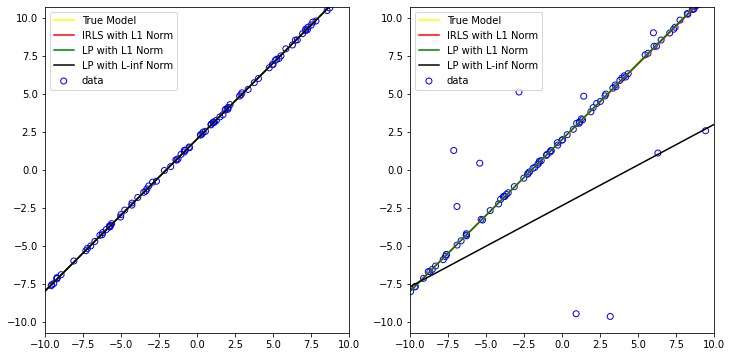

In [ ]:
import warnings

warnings.filterwarnings('ignore')

a = 1
b = 2
outlier_ratios = [0, 0.1]

fig, axs = plt.subplots(1,2)
fig.set_size_inches((12,6))

for i in range(len(outlier_ratios)):
  print('------------- outlier ratio is: ', outlier_ratios[i], '--------------------')
  data = generate_line_data_points(a=a, b=b, outlier_ratio=outlier_ratios[i], tau=0.1, N=100)
  start_1 = time.time()
  a_irls, b_irls, n, res_irls = irls_L1(data , max_iteration=100 , tolerence=0.01)
  end_1 = time.time()
  print('-------------- IRLS ---------------')
  print('IRLS:', 'a =', a_irls, 'b =', b_irls, 'residual =', res_irls, 'run time:', end_1-start_1)
  start_2 = time.time()
  a_L1, b_L1, res_L1 = linear_program(data, norm='L1')
  end_2 = time.time()
  print('-------------- L1 ---------------')
  print('L1:', 'a =', a_L1, 'b =', b_L1, 'residual =', res_L1, 'run time:', end_2-start_2 )
  start_3 = time.time()
  a_Linf, b_Linf, res_Linf = linear_program(data, norm='Linf')
  end_3 = time.time()
  print('-------------- Linf ---------------')
  print('Linf:', 'a =', a_Linf, 'b =', b_Linf, 'residual =', res_Linf, 'run time:', end_3-start_3)
  x = np.linspace(-10,10,100)
  y = a*x + b
  y_irls = a_irls*x+b_irls
  y_L1 = a_L1*x+b_L1
  y_Linf = a_Linf*x+b_Linf

  # plot the results
  axs[i].scatter(data[0, :], data[1, :], facecolors='none', edgecolors='blue', label = 'data')
  axs[i].plot(x, y, 'yellow', label='True Model')
  axs[i].plot(x, y_irls, 'red', label='IRLS with L1 Norm')
  axs[i].plot(x, y_L1, 'green', label='LP with L1 Norm')
  axs[i].plot(x, y_Linf, 'black', label='LP with L-inf Norm')
  axs[i].axis('equal')
  axs[i].set_xlim(-10, 10)
  axs[i].set_ylim(-10, 10)
  axs[i].legend(loc='upper left')  




**Discussion**


> Results

The following figure (from left to right) shows the results of outlier ratios of $0, 0.1$ each respectively.

![](https://drive.google.com/uc?export=view&id=1ZpfTP1AD4-BbnpEU40RMGe4UrDSpO3gx)

> Discussion of Results

The following table shows the parameters of the fitted line obtained by different algorithms:

|Outlier Ratio|0.|0.1|
|:---|:---|:---|
|IRLS with $L_1$ Norm|a = 0.9988, b = 2.0086  |a = 0.9953, b = 1.9815|
|Linear Programming with $L_1$ Norm|a = 0.9991, b = 2.0170 |a = 1.0010, b = 1.9983|
|Linear Programming with $L_\infty$ Norm|a = 1.0001, b = 1.9998 | a = 0.5341, b = -2.3536|

The following table shows the total cost of the fitted line obtained by different algorithms:

|Outlier Ratio|0 |0.1|
|:---|:---|:---|
|IRLS with $L_1$ Norm| 4.9723 |69.3295|
|Linear Programming with $L_1$ Norm|4.9345 |68.8956|
|Linear Programming with $L_\infty$ Norm| 5.0945| 460.3630|

From the two tables above we can easily observe that in the case of outlier ratio of 0, i.e., no outliers, three algorithms gives equally good performance while in the case of outlier ratio of 0.1, only IRLS and linear programming with $L_1$ norm are robust to outliers whereas linear programming with $L_\infty$ is greatly affected by the outliers and thus gives a comparably poor results. 

This is due to the fact that minimizing $L_\infty$ norm is to minimize only the maximum value of $d(y_i,x)$ and thus not allowing any error to be very large. It can be seen as an extreme case of minimizing $L_p$ norm with large $p$-value. This optimization method over-penalizes extreme outliers and thus the cost is comparably large.  

The following table shows the running time of different algorithms:

|Outlier Ratio|0 |0.1|
|:---|:---|:---|
|IRLS with $L_1$ Norm| 0.0008 |0.0017|
|Linear Programming with $L_1$ Norm|0.0900 |0.0761|
|Linear Programming with $L_\infty$ Norm| 0.0608|0.0265 |

From the table above we can easily observe that IRLS with $L_1$ norm is generally much faster than linear programming with $L_1$ and $L_\infty$ norm.